In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import ast

from graphviz import Digraph

import math
from scipy.stats import bernoulli
from scipy.stats import truncnorm
import statistics

from sklearn.linear_model import LogisticRegression

# Synthetic data generation

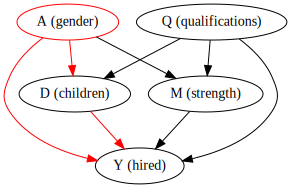

In [ ]:
g = Digraph(comment='causal graph - synthetic dataset')

g.node('A', label='A (gender)', color='red')
g.node('D', label='D (children)')
g.node('M', label='M (strength)')
g.node('Q', label='Q (qualifications)')
g.node('Y', label='Y (hired)')

g.edge('A', 'D', color='red')
g.edge('A', 'M')
g.edge('A', 'Y', color='red')
g.edge('D', 'Y', color='red')
g.edge('M', 'Y')
g.edge('Q', 'D')
g.edge('Q', 'M')
g.edge('Q', 'Y')

g

In [ ]:
# the final data generating process
np.random.seed(1337)

p = 0.6
n = 6000

UA = bernoulli.rvs(p=p, size=n)
A = UA

UQ = np.random.normal(2, 5, n)
UQ[UQ<0] = 0 # import implict assumptions

Q = np.floor(UQ)

UD = truncnorm.rvs((0.1 - 2)/1, (3 - 2)/1, 2, 1, size=n)
UD[UD<0] = 0 # import implict assumptions
D = A + np.floor(0.5*Q*UD)

UM = truncnorm.rvs((0.1 - 3)/2, (3 - 3)/2, 3, 2, size=n)
UM[UM<0] = 0 # import implict assumptions
M = 3*A + 0.4*Q*UM

sigmoid = lambda x: 1/(1+ math.exp(-x))

Y = np.zeros(n)
for i in range(n):
    Y[i] = bernoulli.rvs(sigmoid(-10+5*A[i]+Q[i]+D[i]+M[i]))

In [ ]:
df = pd.DataFrame({'A': A, 'M': M ,'D': D, 'Q': Q,'Y': Y})

# counterfactual values
df['M0'] = df.apply(lambda x: x['M'] - 3 if x['A'] == 1 else x['M'], axis = 1)
df['M1'] = df.apply(lambda x: x['M'] + 3 if x['A'] == 0 else x['M'], axis = 1)
df['D0'] = df.apply(lambda x: x['D']  if x['A'] == 0 else x['D'] - 1, axis = 1)
df['D1'] = df.apply(lambda x: x['D'] if x['A'] == 1 else x['D'] + 1, axis = 1)

print("df", df.shape)
df.head()

df (6000, 9)


,A,M,D,Q,Y,M0,M1,D0,D1
0,1,4.807400,2.0,3.0,1.0,1.807400,4.807400,1.0,2.0
1,1,3.202447,2.0,1.0,1.0,0.202447,3.202447,1.0,2.0
2,1,10.426384,9.0,8.0,1.0,7.426384,10.426384,8.0,9.0
3,1,4.499319,2.0,5.0,1.0,1.499319,4.499319,1.0,2.0
4,1,3.000000,1.0,0.0,0.0,0.000000,3.000000,0.0,1.0


In [ ]:
# write trainining and test set
seed = 1337
df_test = df.sample(n = 1000, random_state=seed)
df_train = df.drop(df_test.index)

# factual df
factual_cols = ['A', 'M', 'D','Q', 'Y','M0', 'D0','D1']
factual_df_test = df_test[factual_cols]
factual_df_train = df_train[factual_cols]
print("factual_df_train", factual_df_train.shape)
print("factual_df_test", factual_df_test.shape)

# factual_df_test.to_csv('file0_TEST.txt', sep=' ', index=False, header=False)
# factual_df_train.to_csv('file0_TRAIN.txt', sep=' ', index=False, header=False)

factual_df_train (5000, 8)
factual_df_test (1000, 8)


In [ ]:
# counterafactual df
counterfactual_cols = ['A', 'M1', 'D1','Q', 'Y','M0', 'D0','D1']
counterafactual_df_test = df_test[counterfactual_cols]
counterafactual_df_train = df_train[counterfactual_cols]
print("counterafactual_df_train", counterafactual_df_train.shape)
print("counterafactual_df_test", counterafactual_df_test.shape)

counterafactual_df_test.to_csv('file0_TEST.txt', sep=' ', index=False, header=False)
counterafactual_df_train.to_csv('file0_TRAIN.txt', sep=' ', index=False, header=False)

counterafactual_df_train (5000, 8)
counterafactual_df_test (1000, 8)


# Model Outputs

- TODO: improve writing data & log files

In [ ]:
# save predictions 
def read_outfile(f_name):
    f = open(f_name, "r")
    out = []
    for l in f.readlines():
        out.append(l)
    f.close()
    return out

def parse_test_line(l: str):
    if "[" in l:
        l = l.split("[")[1]
    if "]" in l:
        l = l.split("]")[0]
    return [ int(float(x)) for x in l.strip().split(" ")]

def parse_predictions(out):

    temp = ast.literal_eval(out[2].replace("training predictions:  ", ""))
    train_preds = [df_train.iloc[0]['Y']] + [x for sublist in temp for x in sublist]

    test_preds = [df_test.iloc[0]['Y']] + sum([parse_test_line(x) for x in out[17:59]],[])

    return train_preds, test_preds 

# counterfactuals for A = 0
test_0_index = df_test[df_test['A'] == 0].index

# counterfactual fairness: sum of absulute difference (counter yhat - factual yhat)
def counterfactual_fairness(counter_prediction, factual_prediction, test_0_index):

    return sum(abs(counter_prediction[counter_prediction.index.isin(test_0_index)]\
                   - factual_prediction[factual_prediction.index.isin(test_0_index)]))/len(test_0_index)

# ETT fairness: absulute value difference between sum of counter predicted y and fautual predicted y
def ett_fairness(counter_prediction, factual_prediction, test_0_index):
    return abs(sum(factual_prediction[factual_prediction.index.isin(test_0_index)])\
               - sum(counter_prediction[counter_prediction.index.isin(test_0_index)]))/len(test_0_index)

In [ ]:
# factual output
factual_out = read_outfile("factual_df.log")
factual_train_preds, factual_test_preds  = parse_predictions(factual_out)
factual_df_test['y_pred'] = factual_test_preds

print("training accuracy: ", (factual_df_train['Y'] == factual_train_preds).sum()/5000)
print("testing accuracy: ", (factual_df_test['Y']  == factual_test_preds).sum()/1000)

training accuracy:  0.9048
testing accuracy:  0.897


In [ ]:
# counterfactual output

counterafactual_out = read_outfile("counterfactual_df3.log")

counterafactual_train_preds, counterafactual_test_preds  = parse_predictions(counterafactual_out)
counterafactual_df_test['y_pred'] = counterafactual_test_preds

print("training accuracy: ", (counterafactual_df_train['Y'] == counterafactual_train_preds).sum()/5000)
print("testing accuracy: ", (counterafactual_df_test['Y']  == counterafactual_test_preds).sum()/1000)

training accuracy:  0.9062
testing accuracy:  0.899


In [ ]:
print(counterfactual_fairness(counterafactual_df_test['y_pred'], factual_df_test['y_pred'], test_0_index))
print(ett_fairness(counterafactual_df_test['y_pred'], factual_df_test['y_pred'], test_0_index))

0.015151515151515152
0.015151515151515152


# Compare with example data

In [ ]:
# explore the data generating process 

# example_df = pd.read_csv('file0_TRAIN_old.txt', sep=' ', header = None)
# example_df.head(20)

In [ ]:
def print_df_info(df):
    # column orders must match A, M, D, Q, Y, M0, D0, D1
    # A
    print(statistics.mean(df.iloc[:,0]))
    print('')

    # M
    print(statistics.mean(df.iloc[:,1]))
    print(statistics.variance(df.iloc[:,1]))
    print(np.min(df.iloc[:,1]))
    print(np.max(df.iloc[:,1]))
    print('')

    # D
    print(statistics.mean(df.iloc[:,2]))
    print(statistics.variance(df.iloc[:,2]))
    print(np.min(df.iloc[:,1]))
    print(np.max(df.iloc[:,2]))
    print('')

    # Q
    print(statistics.mean(df.iloc[:,3]))
    print(statistics.variance(df.iloc[:,3]))
    print(np.min(df.iloc[:,1]))
    print(np.max(df.iloc[:,3]))
    print('')

    # Y
    x = df.iloc[:,:4]
    y = df.iloc[:,4]
    model = LogisticRegression()
    model.fit(x, y)
    r_sq = model.score(x, y)
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)

    # M0
    print(np.min(df.iloc[:,5]))
    print(np.max(df.iloc[:,5]))
    print('')

    # D0
    print(np.min(df.iloc[:,6]))
    print(np.max(df.iloc[:,6]))
    print('')

    # D1
    print(np.min(df.iloc[:,7]))
    print(np.max(df.iloc[:,7]))
    print('')

# print_df_info(df)
# print_df_info(example_df)